# Dispersal vs Ecology Metrics v9


Plots based on ASV-level spatiotemporal anomaly, in the gyre only (site 16 or later).

Key data was produced in `lat_diel_running_means_v3.ipynb`: highcov_dir + 'phyto_ASV_spatiotemporal_group_anoms_v3.csv'


Jones-Kellett et al. figs in this script:
1. Fig. 5 : Euk phyto STA vs. coherence
2. Fig. 6 : Euk major group STA vs. coherence, exponential decay fit
3. Fig. S7 : Cyano STA vs. Abundance 
4. Fig. S8 : Euk major group STA vs. coherence
5. Fig. S9 : Euk minor group STA vs. coherence

Other things in paper from this script:
- Table S3 : Fits of STA vs. coherence & abundance stats
- Eddy enhancement stats
- Table S4 : STA averages

NOTES

v9: Improved lat anom / temporal fit on non-zero data is used

v8: Redefining "near eddy" as <15km from eddy boundary (previously was <25km)
- Boundary work was done on the cluster

----


Lexi Jones-Kellett

Date created: 07/30/25

Last edited: 08/08/25

In [74]:
import csv,math,statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as spy
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from decimal import Decimal
from matplotlib.patches import CirclePolygon
from matplotlib.lines import Line2D
from config import * # directory file paths

In [2]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

Create scatter plots with eddy & latitude information

In [3]:
metadata_df = pd.read_csv(data_dir + 'AVISO_metadata_15km_near_eddy.csv',index_col=0)
metadata_df = metadata_df.set_index('sample_id')
metadata_df

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc
sample_id,,,,,,,,
3,20211119,11:04,31.8350,241.3917,0,0,838480,0
4,20211119,13:10,31.5750,240.9592,0,0,838480,0
5,20211119,15:19,31.3125,240.4938,0,799642,0,0
6,20211119,17:11,31.0850,240.1052,799642,0,0,0
7,20211119,19:04,30.8575,239.7167,0,0,0,0
...,...,...,...,...,...,...,...,...
67,20211126,20:58,17.2820,219.9525,0,0,845344,0
68,20211126,23:04,16.8736,219.9950,0,0,0,845344
69,20211127,01:02,16.4513,219.9996,0,0,0,0


Add column for eddy age

In [4]:
anti_df = pd.read_csv(data_dir + 'AVISO_anti_eddy_G4_crossing_data.csv')
anti_df

,Date,Eddy ID,Age (days),Age (frac of life),Speed (m/s),Center Lon,Center Lat,Contour Lons,Contour Lats
0,20211119,799642,10,0.108696,0.1355,240.109833,31.375994,"[239.88, 240.12, 240.13, 240.38, 240.39, 240.4...","[30.89, 30.91, 30.91, 31.09, 31.13, 31.369999,..."
1,20211123,799833,12,0.214286,0.1076,225.904083,22.250608,"[225.38, 225.62, 226.1, 226.37, 226.62, 226.95...","[21.57, 21.539999, 21.63, 21.74, 21.77, 21.88,..."


In [5]:
cyc_df = pd.read_csv(data_dir + 'AVISO_cyc_eddy_G4_crossing_data.csv')
cyc_df

,Date,Eddy ID,Age (days),Age (frac of life),Speed (m/s),Center Lon,Center Lat,Contour Lons,Contour Lats
0,20211119,838480,131,0.873333,0.1804,241.245865,31.479284,"[241.12, 240.98999, 240.95, 240.88, 240.8, 240...","[30.609999, 30.88, 31.13, 31.34, 31.619999, 31..."
1,20211119,846424,33,0.286957,0.2098,238.738678,31.000278,"[238.38, 238.13, 238.03, 238.06, 238.20999, 23...","[30.09, 30.21, 30.369999, 30.619999, 30.869999..."
2,20211120,846424,34,0.295652,0.2080,238.717041,31.008432,"[238.38, 238.12, 238.0, 238.06, 238.23999, 238...","[30.08, 30.189999, 30.38, 30.619999, 30.869999..."
3,20211121,849094,1,0.038462,0.0449,234.287827,27.966232,"[234.12, 233.97, 233.88, 233.87, 233.86, 233.8...","[27.67, 27.88, 28.0, 28.019999, 28.119999, 28...."
4,20211121,831329,224,0.736842,0.1646,232.931168,26.213045,"[232.88, 232.63, 232.20999, 232.05, 231.93, 23...","[25.369999, 25.519999, 25.869999, 26.13, 26.61..."
5,20211122,831329,225,0.740132,0.1693,232.911194,26.217823,"[232.88, 232.63, 232.19, 232.02, 231.9, 231.98...","[25.369999, 25.51, 25.88, 26.14, 26.63, 26.88,..."
6,20211122,844202,63,0.443662,0.0716,228.087341,23.910452,"[227.88, 227.65, 227.64, 227.65, 227.63, 227.6...","[23.279999, 23.369999, 23.39, 23.619999, 23.86..."
7,20211123,823188,326,0.806931,0.1998,223.682907,20.675846,"[222.51, 222.51, 222.62, 222.73999, 222.92, 22...","[19.619999, 19.869999, 20.619999, 20.88, 21.13..."
8,20211124,823188,327,0.809406,0.2029,223.662094,20.700729,"[222.45, 222.54001, 222.53, 222.57, 223.13, 22...","[19.63, 20.119999, 20.369999, 20.619999, 21.66..."
9,20211124,847844,20,0.210526,0.1055,221.653381,19.704439,"[221.62, 221.41, 221.37, 221.19, 221.15, 221.1...","[19.3, 19.369999, 19.41, 19.619999, 19.869999,..."


In [6]:
eddy_age_days = []
eddy_age_frac = []

for index, row in metadata_df.iterrows():    
    if row.in_cyc != 0:
        ind = np.where((cyc_df['Date'] == row.date) & (cyc_df['Eddy ID'] == row.in_cyc))[0][0]
        eddy_age_days.append(cyc_df.iloc[ind]['Age (days)'])
        eddy_age_frac.append(cyc_df.iloc[ind]['Age (frac of life)'])
        
    elif row.near_cyc != 0:
        ind = np.where((cyc_df['Date'] == row.date) & (cyc_df['Eddy ID'] == row.near_cyc))[0][0]
        eddy_age_days.append(cyc_df.iloc[ind]['Age (days)'])
        eddy_age_frac.append(cyc_df.iloc[ind]['Age (frac of life)'])
        
    elif row.in_anti != 0:
        ind = np.where((anti_df['Date'] == row.date) & (anti_df['Eddy ID'] == row.in_anti))[0][0]
        eddy_age_days.append(anti_df.iloc[ind]['Age (days)'])
        eddy_age_frac.append(anti_df.iloc[ind]['Age (frac of life)'])
        
    elif row.near_anti != 0:
        ind = np.where((anti_df['Date'] == row.date) & (anti_df['Eddy ID'] == row.near_anti))[0][0]
        eddy_age_days.append(anti_df.iloc[ind]['Age (days)'])
        eddy_age_frac.append(anti_df.iloc[ind]['Age (frac of life)'])
    else:
        eddy_age_days.append(np.nan)
        eddy_age_frac.append(np.nan)

In [7]:
metadata_df['eddy_age_days'] = eddy_age_days
metadata_df['eddy_age_frac'] = eddy_age_frac
metadata_df.head()

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,eddy_age_days,eddy_age_frac
sample_id,,,,,,,,,,
3,20211119,11:04,31.8350,241.3917,0,0,838480,0,131.0,0.873333
4,20211119,13:10,31.5750,240.9592,0,0,838480,0,131.0,0.873333
5,20211119,15:19,31.3125,240.4938,0,799642,0,0,10.0,0.108696
6,20211119,17:11,31.0850,240.1052,799642,0,0,0,10.0,0.108696
7,20211119,19:04,30.8575,239.7167,0,0,0,0,NaN,NaN


In [8]:
print(max(metadata_df['eddy_age_days']))
print(min(metadata_df['eddy_age_days']))

print(max(metadata_df['eddy_age_frac']))
print(min(metadata_df['eddy_age_frac']))

327.0
1.0
0.8733333333333333
0.0384615384615384


Add a column for eddy color to df for plotting

In [9]:
eddy_color = []
for s in metadata_df.index:
    if int(metadata_df.loc[s]['in_cyc']) != 0: 
        eddy_color.append('mediumblue')
    elif int(metadata_df.loc[s]['near_cyc']) != 0: 
        eddy_color.append('cornflowerblue')
    elif int(metadata_df.loc[s]['in_anti']) != 0: 
        eddy_color.append('firebrick')
    elif int(metadata_df.loc[s]['near_anti']) != 0: 
        eddy_color.append('lightcoral')
    else:
        eddy_color.append('k')

In [10]:
metadata_df['eddy_color'] = eddy_color
metadata_df.head()

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,eddy_age_days,eddy_age_frac,eddy_color
sample_id,,,,,,,,,,,
3,20211119,11:04,31.8350,241.3917,0,0,838480,0,131.0,0.873333,mediumblue
4,20211119,13:10,31.5750,240.9592,0,0,838480,0,131.0,0.873333,mediumblue
5,20211119,15:19,31.3125,240.4938,0,799642,0,0,10.0,0.108696,lightcoral
6,20211119,17:11,31.0850,240.1052,799642,0,0,0,10.0,0.108696,firebrick
7,20211119,19:04,30.8575,239.7167,0,0,0,0,NaN,NaN,k


In [11]:
coh_df = pd.read_csv(data_dir + 'coh_days_200day_backward_runtime_20min_timestep_6hr_output_freq_1000_gaussian_particles_0.025_std_dist_CMEMS_OSCAR_interim.csv',header=1,index_col='sample_id')
coh_df = coh_df.reset_index()
coh_df = coh_df.drop('0',axis='columns')
coh_df.head()

,sample_id,CMEMS_coherence_days_run0,CMEMS_coherence_days_run1,CMEMS_coherence_days_run2,OSCAR_coherence_days_run0,OSCAR_coherence_days_run1,OSCAR_coherence_days_run2
0,3,21.50,21.50,20.75,175.75,175.25,173.75
1,4,19.25,19.50,18.75,24.50,25.00,23.50
2,5,43.25,43.00,42.75,59.50,59.25,58.75
3,6,56.75,56.50,46.25,14.75,14.75,14.00
4,7,49.50,49.25,49.00,30.25,30.00,29.50


Get average of the 3 runs for each CMEMS and OSCAR (values calculated on cluster)

In [12]:
coh_mean_df = pd.DataFrame({'sample_id':coh_df.sample_id,
                            'CMEMS_avg_coh':np.mean((coh_df.CMEMS_coherence_days_run0,coh_df.CMEMS_coherence_days_run1,coh_df.CMEMS_coherence_days_run2),axis=0),
                           'OSCAR_avg_coh':np.mean((coh_df.OSCAR_coherence_days_run0,coh_df.OSCAR_coherence_days_run1,coh_df.OSCAR_coherence_days_run2),axis=0)})
coh_mean_df.head()

,sample_id,CMEMS_avg_coh,OSCAR_avg_coh
0,3,21.250000,174.916667
1,4,19.166667,24.333333
2,5,43.000000,59.166667
3,6,53.166667,14.500000
4,7,49.250000,29.916667


In [13]:
coh_mean_df.iloc[np.where(coh_mean_df.CMEMS_avg_coh > 90)[0]]

,sample_id,CMEMS_avg_coh,OSCAR_avg_coh
5,8,157.250000,57.833333
15,19,97.083333,61.333333
26,30,119.583333,63.000000
31,35,90.750000,131.250000
33,37,130.500000,69.916667
35,39,156.166667,63.000000
37,41,96.000000,111.500000
46,51,99.583333,125.333333
55,60,131.583333,69.250000
60,67,110.166667,9.083333


In [14]:
max(coh_mean_df.CMEMS_avg_coh)

157.25

In [15]:
temp_df = pd.read_csv(data_dir + 'temp_anomalies_by_station.csv')#,index_col='sample_id')
temp_df = temp_df.drop('Unnamed: 0',axis='columns')
temp_df.head()

,sample_id,temp_anoms
0,3,NaN
1,4,NaN
2,5,NaN
3,6,NaN
4,7,NaN


Open ASV-level spatiotemporal anomalies, summed by group 

In [16]:
div_df = pd.read_csv(highcov_dir + 'phyto_ASV_spatiotemporal_group_anoms_v3.csv',index_col=0)
div_df.head()

,Prymnesiophyte,Dinoflagellate,Dictyochophyte,Chrysophyte,Unknown Eukaryote Chloroplast,Pelagophyte,Diatom,Chlorophyte,Prasinodermophyte,Cryptophyte,Diazotroph,Picocyanobacteria
sample_id,,,,,,,,,,,,
16,-333.969629,89.987036,-49.977381,-179.647262,-168.192228,-76.805029,27.143210,-69.382566,-12.848812,10.185406,-6.580226,-3967.232713
17,-96.809486,483.068234,-59.008683,-124.678090,-244.454688,-16.290086,20.008678,-20.601396,-7.666102,-0.882804,-16.200813,-6257.738603
18,1001.268869,734.456012,680.255476,215.774260,68.056802,110.829831,68.528971,9.576012,-9.852365,-2.745265,-0.984962,5610.385205
19,-1167.595661,-863.236283,-597.277733,-12.009328,-1.901571,-105.905127,-44.062083,127.923658,12.454472,-2.172479,-28.346925,-15423.968296
20,-350.564931,627.572379,-225.305894,-238.519809,4.178096,48.921635,-64.909874,41.297409,21.731504,-4.229902,7.394596,6379.209983


In [17]:
euk_sum = pd.DataFrame({'Eukaryotes':div_df.drop(['Picocyanobacteria','Diazotroph'], axis=1).sum(axis=1)})
euk_sum.head()

,Eukaryotes
sample_id,
16,-763.507255
17,-67.314424
18,2876.148602
19,-2653.782135
20,-139.829386


In [18]:
div_df = pd.concat((div_df,euk_sum),axis=1)

In [19]:
div_merged_df = pd.merge(pd.merge(pd.merge(metadata_df,coh_mean_df,on='sample_id'),temp_df,on='sample_id'),div_df,on='sample_id')
div_merged_df['Cyanobacteria'] = np.sum((div_merged_df['Picocyanobacteria'],div_merged_df['Diazotroph']),axis=0)
div_merged_df.head()

,sample_id,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,eddy_age_days,...,Unknown Eukaryote Chloroplast,Pelagophyte,Diatom,Chlorophyte,Prasinodermophyte,Cryptophyte,Diazotroph,Picocyanobacteria,Eukaryotes,Cyanobacteria
0,16,20211120,10:54,29.0000,236.5574,0,0,0,0,NaN,...,-168.192228,-76.805029,27.143210,-69.382566,-12.848812,10.185406,-6.580226,-3967.232713,-763.507255,-3973.812939
1,17,20211120,12:44,28.7390,236.1088,0,0,0,0,NaN,...,-244.454688,-16.290086,20.008678,-20.601396,-7.666102,-0.882804,-16.200813,-6257.738603,-67.314424,-6273.939416
2,18,20211120,14:43,28.5030,235.7140,0,0,0,0,NaN,...,68.056802,110.829831,68.528971,9.576012,-9.852365,-2.745265,-0.984962,5610.385205,2876.148602,5609.400243
3,19,20211121,02:03,28.2847,235.3517,0,0,0,0,NaN,...,-1.901571,-105.905127,-44.062083,127.923658,12.454472,-2.172479,-28.346925,-15423.968296,-2653.782135,-15452.315221
4,20,20211121,04:04,28.0397,234.9534,0,0,0,0,NaN,...,4.178096,48.921635,-64.909874,41.297409,21.731504,-4.229902,7.394596,6379.209983,-139.829386,6386.604579


## Stat Tests

In [20]:
div_merged_df_not_eddy_most_coh = div_merged_df.iloc[np.where((div_merged_df.CMEMS_avg_coh > 90) & (div_merged_df.in_cyc == 0) & (div_merged_df.near_cyc == 0))[0]]
div_merged_df_not_eddy_most_coh

,sample_id,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,eddy_age_days,...,Unknown Eukaryote Chloroplast,Pelagophyte,Diatom,Chlorophyte,Prasinodermophyte,Cryptophyte,Diazotroph,Picocyanobacteria,Eukaryotes,Cyanobacteria
3,19,20211121,02:03,28.2847,235.3517,0,0,0,0,NaN,...,-1.901571,-105.905127,-44.062083,127.923658,12.454472,-2.172479,-28.346925,-15423.968296,-2653.782135,-15452.315221
14,30,20211122,04:03,25.7446,231.1433,0,0,0,0,NaN,...,-128.304599,-141.317758,27.675279,-35.791291,-14.538153,15.668338,295.657496,489.777043,-2055.607729,785.434539
19,35,20211122,13:13,24.6388,229.3400,0,0,0,0,NaN,...,-101.631473,-48.815478,29.972427,-3.741113,-35.193226,-0.733590,-352.705396,-285.954178,-4944.949596,-638.659574
25,41,20211123,01:25,23.1732,226.9761,0,0,0,0,NaN,...,-124.235898,-42.870764,-56.006842,-35.391165,8.885928,-0.194492,100.654795,-3160.166700,-824.047789,-3059.511904
43,60,20211126,06:00,18.7320,220.6000,0,0,0,0,NaN,...,-94.367624,-150.106697,-57.650588,-27.412015,30.615310,0.320350,-243.460144,-18544.547062,-1777.611024,-18788.007206
50,69,20211127,01:02,16.4513,219.9996,0,0,0,0,NaN,...,-32.555594,-413.383574,112.915353,-46.998358,-11.660020,-0.297546,-1.807177,49763.812238,-3072.993385,49762.005061
51,70,20211127,03:00,16.0360,219.9977,0,0,0,0,NaN,...,124.563151,-119.165164,-17.622269,76.978405,2.535855,0.281850,-4.184639,-10185.300421,-1599.209709,-10189.485059


In [21]:
div_merged_df_eddy_most_coh = div_merged_df.iloc[np.where((div_merged_df.CMEMS_avg_coh > 90) & ((div_merged_df.in_cyc != 0) | (div_merged_df.near_cyc != 0)))[0]]
div_merged_df_eddy_most_coh

,sample_id,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,eddy_age_days,...,Unknown Eukaryote Chloroplast,Pelagophyte,Diatom,Chlorophyte,Prasinodermophyte,Cryptophyte,Diazotroph,Picocyanobacteria,Eukaryotes,Cyanobacteria
21,37,20211122,17:22,24.1350,228.5250,0,0,844202,0,63.0,...,-25.258010,-18.242299,16.896929,14.429070,-6.068094,-1.827530,-55.665802,-3778.216256,1003.846945,-3833.882058
23,39,20211122,21:12,23.6708,227.7761,0,0,844202,0,63.0,...,28.248940,-56.580455,-64.641336,30.267494,42.196903,-0.168685,375.061113,16426.019021,1376.831833,16801.080134
34,51,20211124,00:20,21.0504,223.6003,0,0,823188,0,327.0,...,128.942082,133.350701,169.957396,112.954162,20.353795,-0.576477,-108.152517,41723.599528,1606.672509,41615.447011
48,67,20211126,20:58,17.2820,219.9525,0,0,845344,0,53.0,...,-6.397928,187.764749,-24.554673,-62.111266,14.562689,0.192559,-8.319708,247.808977,-734.524600,239.489269
49,68,20211126,23:04,16.8736,219.9950,0,0,0,845344,53.0,...,-81.691457,40.858637,-35.837324,-69.184457,-19.594111,0.322925,-5.211045,34583.947932,2290.287802,34578.736887


#### Compare Eukaryote Anomalies:

In [27]:
print('In Eddy:')
print(np.mean(div_merged_df_eddy_most_coh.Eukaryotes))
print(statistics.stdev(div_merged_df_eddy_most_coh.Eukaryotes))

print('\nOut Eddy:')
print(np.mean(div_merged_df_not_eddy_most_coh.Eukaryotes))
print(statistics.stdev(div_merged_df_not_eddy_most_coh.Eukaryotes))

In Eddy:
1108.6228980533604
1131.8670518264485

Out Eddy:
-2418.3144809180208
1330.5769744071351


Unequal Variance T-Test: Used when the # of samples in each group is different & the variance of the two datasets is different; also called Welch's t-test

https://www.investopedia.com/terms/t/t-test.asp#:~:text=A%20t%2Dtest%20is%20an,flipping%20a%20coin%20100%20times

https://www.geeksforgeeks.org/welchs-t-test-in-python/

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

For the one-tailed T-test function, `alternative: 'greater'` is testing the hypothesis that the mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample

In [31]:
print(statistics.variance(div_merged_df_eddy_most_coh.Eukaryotes))
print(statistics.variance(div_merged_df_not_eddy_most_coh.Eukaryotes))
print(statistics.variance(div_merged_df_eddy_most_coh.Eukaryotes)/statistics.variance(div_merged_df_not_eddy_most_coh.Eukaryotes))

1281123.0230102963
1770435.084822446
0.7236204444845703


In [32]:
spy.ttest_ind(div_merged_df_eddy_most_coh.Eukaryotes,div_merged_df_not_eddy_most_coh.Eukaryotes,equal_var=False,alternative='greater')

Ttest_indResult(statistic=4.942850502305268, pvalue=0.0003325899197420553)

In [33]:
spy.ttest_ind(div_merged_df_eddy_most_coh.Eukaryotes,div_merged_df_not_eddy_most_coh.Eukaryotes,equal_var=True,alternative='greater')

Ttest_indResult(statistic=4.799995380098687, pvalue=0.0003618181253608003)

## Results Plot: Euk STA vs Coh

In [34]:
def sub_plot_param_v_coherence(a,param,coh,labels=False,colorbar='lat',
                           include_cyc=True,include_anti=True,include_bg=True):
        
    if colorbar == 'lat':
        colorbar_data = div_merged_df.latitude
        cb_label = 'Latitude ($^{\circ}$N)'
        vmin,vmax = 15,29
        cmap = 'Greys'
    elif colorbar == 'temp_anoms':
        colorbar_data = div_merged_df.temp_anoms
        cb_label = 'Temperature Anomaly ($^{\circ}$C)'
        vmin,vmax = -0.7,0.7
        cmap = 'coolwarm'
    elif colorbar == 'eddy_age_days':
        colorbar_data = div_merged_df.eddy_age_days
        cb_label = 'Eddy Age (days)'
        vmin,vmax = min(metadata_df['eddy_age_days']),max(metadata_df['eddy_age_days'])
        cmap = 'Greys'
    elif colorbar == 'eddy_age_frac':
        colorbar_data = div_merged_df.eddy_age_frac
        cb_label = 'Eddy Age (Fraction of Lifespan)'
        vmin,vmax = min(metadata_df['eddy_age_frac']),max(metadata_df['eddy_age_frac'])
        cmap = 'Greys'
        
    x = coh
    y = param
    colors = colorbar_data
    edgecolors = div_merged_df.eddy_color
    sample_ids = div_merged_df.sample_id
        
    if include_anti == False:
        anti_inds = div_merged_df['eddy_color'].ne('firebrick') & div_merged_df['eddy_color'].ne('lightcoral')
        x = x[anti_inds]
        y = y[anti_inds]
        colors = colors[anti_inds]
        edgecolors = edgecolors[anti_inds]
        sample_ids = sample_ids[anti_inds]
        
    if include_cyc == False:
        cyc_inds = div_merged_df['eddy_color'].ne('mediumblue') & div_merged_df['eddy_color'].ne('cornflowerblue')
        x = x[cyc_inds]
        y = y[cyc_inds]
        colors = colors[cyc_inds]
        edgecolors = edgecolors[cyc_inds]
        sample_ids = sample_ids[cyc_inds]
    
    if include_bg == False:
        bg_inds = div_merged_df['eddy_color'].ne('k')
        x = x[bg_inds]
        y = y[bg_inds]
        colors = colors[bg_inds]
        edgecolors = edgecolors[bg_inds]
        sample_ids = sample_ids[bg_inds]

    linewidth=2
    
    shapes = []
    for e in np.arange(0,len(edgecolors)):
        if (list(edgecolors)[e] == 'mediumblue') or (list(edgecolors)[e] == 'firebrick'):
            sc = a.scatter(list(x)[e],list(y)[e],c=list(colors)[e],edgecolor=list(edgecolors)[e],
                          marker='s',cmap=cmap,linewidth=linewidth,s=200,vmin=vmin,vmax=vmax)

        elif (list(edgecolors)[e] == 'cornflowerblue') or (list(edgecolors)[e] == 'lightcoral'):
            sc = a.scatter(list(x)[e],list(y)[e],c=list(colors)[e],edgecolor=list(edgecolors)[e],
                          marker='^',cmap=cmap,linewidth=linewidth,s=200,vmin=vmin,vmax=vmax)
        else:
            sc = a.scatter(list(x)[e],list(y)[e],c=list(colors)[e],edgecolor=list(edgecolors)[e],
                          cmap=cmap,linewidth=linewidth,s=200,vmin=vmin,vmax=vmax)
    
    if labels==True:    
        for i in np.arange(0,len(x.tolist())):
            a.text(x.tolist()[i],y.tolist()[i],sample_ids.tolist()[i],
                   horizontalalignment='center',verticalalignment='bottom')
    
    # FIT REGRESSION TO DATA
    slope, intercept, r_value, p_value, std_err = spy.linregress(x, y)

    x_sorted = sorted(x)
    fit = [slope*i+intercept for i in x_sorted]
    if p_value < 0.001:
        a.plot(x_sorted,fit,label='m = %s\nr = %s\np < 0.001'%(round(slope,1),round(r_value,3)),c='k',linestyle='--')
    else:
        a.plot(x_sorted,fit,label='m = %s\nr = %s\np = %s'%(round(slope,1),round(r_value,3),round(p_value,3)),c='k',linestyle='--')
    a.legend()
    
    a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    a.set_ylim(min(param)+min(param)/4,max(param)+np.abs(min(param)/4))
    
    return sc

/var/folders/yd/5vf5xvpn14q42xgt5trcdktc0000gn/T/ipykernel_95026/3008593280.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


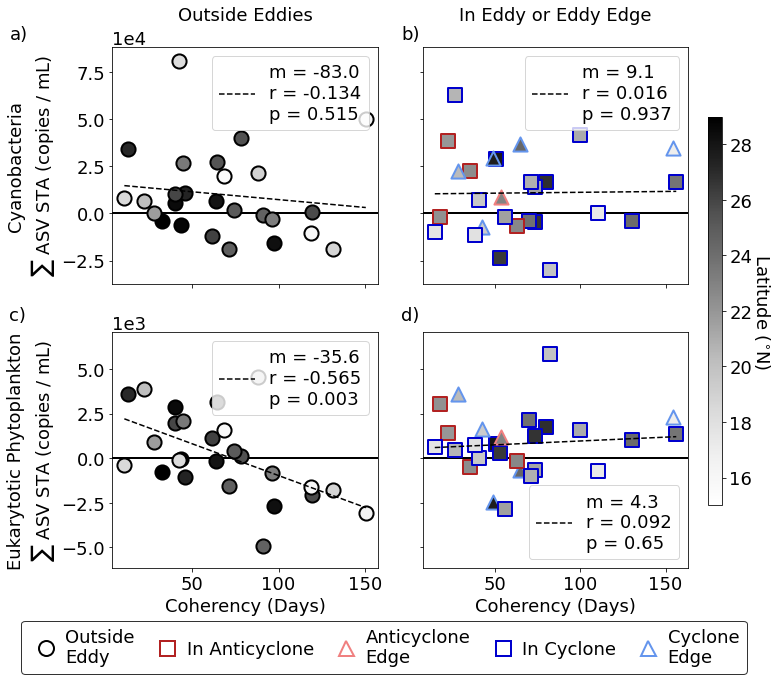

In [35]:
fig,ax = plt.subplots(2,2,figsize=(10,9)) # (width,height)
sc = sub_plot_param_v_coherence(ax[0,0],div_merged_df.Cyanobacteria,div_merged_df.CMEMS_avg_coh,colorbar='lat',
                           include_cyc=False,include_anti=False,include_bg=True)
sub_plot_param_v_coherence(ax[0,1],div_merged_df.Cyanobacteria,div_merged_df.CMEMS_avg_coh,colorbar='lat',
                           include_cyc=True,include_anti=True,include_bg=False)
sub_plot_param_v_coherence(ax[1,0],div_merged_df.Eukaryotes,div_merged_df.CMEMS_avg_coh,labels=False,colorbar='lat',
                           include_cyc=False,include_anti=False,include_bg=True)
sub_plot_param_v_coherence(ax[1,1],div_merged_df.Eukaryotes,div_merged_df.CMEMS_avg_coh,colorbar='lat',
                            include_cyc=True,include_anti=True,include_bg=False)

for i, a in enumerate(ax.flat):
    a.axhline(0,c='k',linewidth=2,zorder=0)

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])

ax[0,0].set_ylabel('Cyanobacteria\n$\sum$ ASV STA (copies / mL)')
ax[1,0].set_ylabel('Eukarytotic Phytoplankton\n$\sum$ ASV STA (copies / mL)')
ax[1,0].set_xlabel('Coherency (Days)')
ax[1,1].set_xlabel('Coherency (Days)')

ax[0,0].set_title('Outside Eddies\n')
ax[0,1].set_title('In Eddy or Eddy Edge\n')

ax[0,0].text(-56,9.25*(10**4),'a)')
ax[0,1].text(-5,9.25*(10**4),'b)')
ax[1,0].text(-56,7.75*(10**3),'c)')
ax[1,1].text(-5,7.75*(10**3),'d)')

# Colorbar
cb_ax = fig.add_axes([1, 0.2, 0.02, 0.6]) # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cb_ax)
cb_ax.tick_params(axis='both', labelsize=fontsize)
cb_ax.set_ylabel('Latitude ($^{\circ}$N)',rotation=270,labelpad=20,fontsize=fontsize)    

### Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Outside\nEddy', markeredgecolor='k', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='s', color='w', label='In Anticyclone', markeredgecolor='firebrick', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='^', color='w', label='Anticyclone\nEdge', markeredgecolor='lightcoral', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='s', color='w', label='In Cyclone', markeredgecolor='mediumblue', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='^', color='w', label='Cyclone\nEdge', markeredgecolor='cornflowerblue', markersize=15,markeredgewidth=2)]

legend = plt.legend(handles=legend_elements,
    loc="lower center", # "upper center" puts it below the line
    ncol=5,
    bbox_to_anchor=(0.55, -0.06),
    borderaxespad=0,
    bbox_transform=fig.transFigure,
    handletextpad=0.07,
    columnspacing=0.8)
legend.legendPatch.set_edgecolor("k")

############################################################

plt.tight_layout()
#plt.savefig(euk_paper_dir + 'figs/coh_vs_abundance_15km_edge_v3.pdf',dpi=350, bbox_inches='tight', format='pdf')

#### Eukaryotes only

/var/folders/yd/5vf5xvpn14q42xgt5trcdktc0000gn/T/ipykernel_95026/2595582364.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


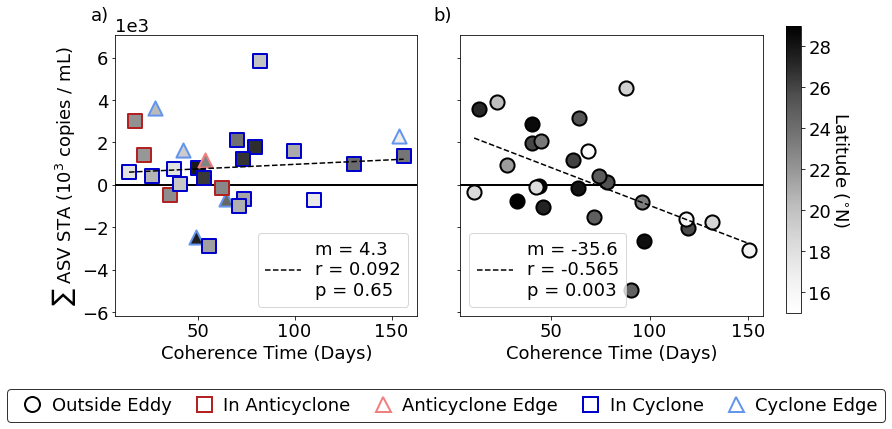

In [36]:
fig,ax = plt.subplots(1,2,figsize=(10.5,5.5)) # (width,height)

sub_plot_param_v_coherence(ax[0],div_merged_df.Eukaryotes,div_merged_df.CMEMS_avg_coh,colorbar='lat',
                            include_cyc=True,include_anti=True,include_bg=False)
sc = sub_plot_param_v_coherence(ax[1],div_merged_df.Eukaryotes,div_merged_df.CMEMS_avg_coh,labels=False,colorbar='lat',
                           include_cyc=False,include_anti=False,include_bg=True)

for i, a in enumerate(ax.flat):
    a.axhline(0,c='k',linewidth=2,zorder=0)

ax[1].set_yticklabels([])

ax[0].set_ylabel('$\sum$ ASV STA ($10^3$ copies / mL)')
ax[0].set_xlabel('Coherence Time (Days)')
ax[1].set_xlabel('Coherence Time (Days)')

#ax[0].set_title('Outside Eddies\n')
#ax[1].set_title('In Eddy or Eddy Edge\n')

ax[0].text(-5,7.75*(10**3),'a)')
ax[1].text(-10,7.75*(10**3),'b)')

# Colorbar
cb_ax = fig.add_axes([1, 0.175, 0.02, 0.725]) # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cb_ax)
cb_ax.tick_params(axis='both', labelsize=fontsize)
cb_ax.set_ylabel('Latitude ($^{\circ}$N)',rotation=270,labelpad=20,fontsize=fontsize)    

### Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Outside Eddy', markeredgecolor='k', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='s', color='w', label='In Anticyclone', markeredgecolor='firebrick', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='^', color='w', label='Anticyclone Edge', markeredgecolor='lightcoral', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='s', color='w', label='In Cyclone', markeredgecolor='mediumblue', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='^', color='w', label='Cyclone Edge', markeredgecolor='cornflowerblue', markersize=15,markeredgewidth=2)]

legend = plt.legend(handles=legend_elements,
    loc="lower center", # "upper center" puts it below the line
    ncol=5,
    bbox_to_anchor=(0.55, -0.1),
    borderaxespad=0,
    bbox_transform=fig.transFigure,
    handletextpad=0.07,
    columnspacing=0.8)
legend.legendPatch.set_edgecolor("k")

############################################################

plt.tight_layout()
#plt.savefig(euk_paper_dir + 'figs/prelim/coh_vs_abundance_15km_edge_euk_only_v3.pdf',dpi=350, bbox_inches='tight', format='pdf')

#### Cyanobacteria only

/var/folders/yd/5vf5xvpn14q42xgt5trcdktc0000gn/T/ipykernel_95026/4207071367.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


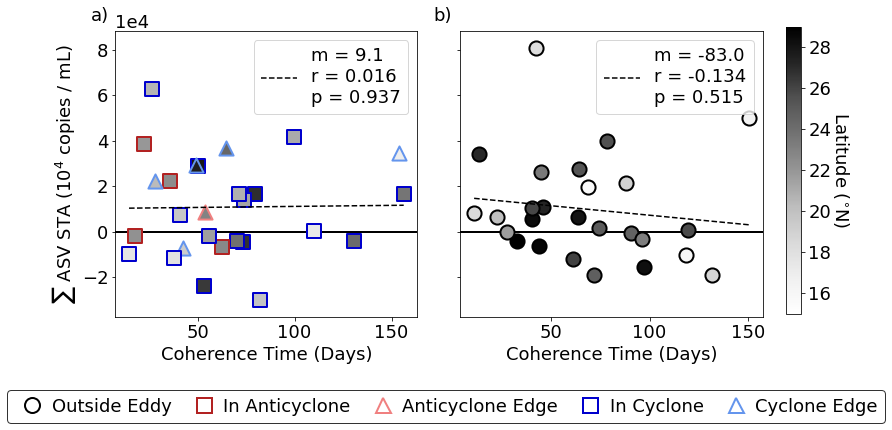

In [37]:
fig,ax = plt.subplots(1,2,figsize=(10.5,5.5)) # (width,height)

sub_plot_param_v_coherence(ax[0],div_merged_df.Cyanobacteria,div_merged_df.CMEMS_avg_coh,colorbar='lat',
                            include_cyc=True,include_anti=True,include_bg=False)
sc = sub_plot_param_v_coherence(ax[1],div_merged_df.Cyanobacteria,div_merged_df.CMEMS_avg_coh,labels=False,colorbar='lat',
                           include_cyc=False,include_anti=False,include_bg=True)

for i, a in enumerate(ax.flat):
    a.axhline(0,c='k',linewidth=2,zorder=0)

ax[1].set_yticklabels([])

ax[0].set_ylabel('$\sum$ ASV STA ($10^4$ copies / mL)')
ax[0].set_xlabel('Coherence Time (Days)')
ax[1].set_xlabel('Coherence Time (Days)')

#ax[0].set_title('Outside Eddies\n')
#ax[1].set_title('In Eddy or Eddy Edge\n')

ax[0].text(-5,9.25*(10**4),'a)')
ax[1].text(-10,9.25*(10**4),'b)')

# Colorbar
cb_ax = fig.add_axes([1, 0.175, 0.02, 0.725]) # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cb_ax)
cb_ax.tick_params(axis='both', labelsize=fontsize)
cb_ax.set_ylabel('Latitude ($^{\circ}$N)',rotation=270,labelpad=20,fontsize=fontsize)    

### Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Outside Eddy', markeredgecolor='k', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='s', color='w', label='In Anticyclone', markeredgecolor='firebrick', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='^', color='w', label='Anticyclone Edge', markeredgecolor='lightcoral', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='s', color='w', label='In Cyclone', markeredgecolor='mediumblue', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='^', color='w', label='Cyclone Edge', markeredgecolor='cornflowerblue', markersize=15,markeredgewidth=2)]

legend = plt.legend(handles=legend_elements,
    loc="lower center", # "upper center" puts it below the line
    ncol=5,
    bbox_to_anchor=(0.55, -0.1),
    borderaxespad=0,
    bbox_transform=fig.transFigure,
    handletextpad=0.07,
    columnspacing=0.8)
legend.legendPatch.set_edgecolor("k")

############################################################

plt.tight_layout()
#plt.savefig(euk_paper_dir + 'figs/supp/coh_vs_abundance_15km_edge_cyan_only_v3.pdf',dpi=350, bbox_inches='tight', format='pdf')

#### Pro vs Syn

In [38]:
pro_syn = pd.read_csv(isme_dir + 'pro_syn_assignments.csv',index_col=0)

In [39]:
cyan_ASV_lat_temp_anom_sorted_df = pd.read_csv(highcov_dir + 'cyan_phyto_ASV_spatiotemporal_anoms_v3.csv')

In [40]:
pro_tax = list(pro_syn[pro_syn['Assignment']=='Prochlorococcus'].index)
pro_sum = (cyan_ASV_lat_temp_anom_sorted_df.loc[:, cyan_ASV_lat_temp_anom_sorted_df.columns.isin(pro_tax)]).sum(axis=1)

In [41]:
syn_tax = list(pro_syn[pro_syn['Assignment']=='Synechococcus'].index)
syn_sum = (cyan_ASV_lat_temp_anom_sorted_df.loc[:, cyan_ASV_lat_temp_anom_sorted_df.columns.isin(syn_tax)]).sum(axis=1)

/var/folders/yd/5vf5xvpn14q42xgt5trcdktc0000gn/T/ipykernel_95026/7947869.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


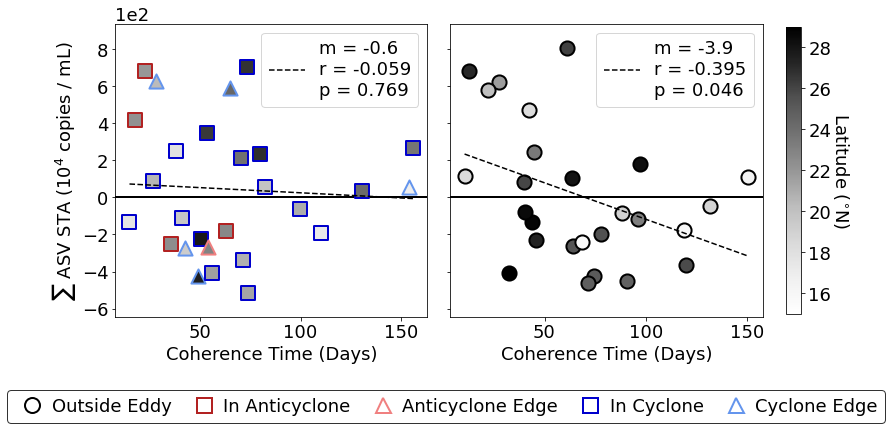

In [42]:
fig,ax = plt.subplots(1,2,figsize=(10.5,5.5)) # (width,height)

# PROCHLOROCOCCUS ONLY 
#sub_plot_param_v_coherence(ax[0],pro_sum,div_merged_df.CMEMS_avg_coh,colorbar='lat',
#                            include_cyc=True,include_anti=True,include_bg=False)
#sc = sub_plot_param_v_coherence(ax[1],pro_sum,div_merged_df.CMEMS_avg_coh,labels=False,colorbar='lat',
#                           include_cyc=False,include_anti=False,include_bg=True)

# SYNECHOCOCCUS ONLY 
sub_plot_param_v_coherence(ax[0],syn_sum,div_merged_df.CMEMS_avg_coh,colorbar='lat',
                            include_cyc=True,include_anti=True,include_bg=False)
sc = sub_plot_param_v_coherence(ax[1],syn_sum,div_merged_df.CMEMS_avg_coh,labels=False,colorbar='lat',
                           include_cyc=False,include_anti=False,include_bg=True)

for i, a in enumerate(ax.flat):
    a.axhline(0,c='k',linewidth=2,zorder=0)

ax[1].set_yticklabels([])

ax[0].set_ylabel('$\sum$ ASV STA ($10^4$ copies / mL)')
ax[0].set_xlabel('Coherence Time (Days)')
ax[1].set_xlabel('Coherence Time (Days)')

#ax[0].set_title('Outside Eddies\n')
#ax[1].set_title('In Eddy or Eddy Edge\n')

#ax[0].text(-5,9.25*(10**4),'a)')
#ax[1].text(-10,9.25*(10**4),'b)')

# Colorbar
cb_ax = fig.add_axes([1, 0.175, 0.02, 0.725]) # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cb_ax)
cb_ax.tick_params(axis='both', labelsize=fontsize)
cb_ax.set_ylabel('Latitude ($^{\circ}$N)',rotation=270,labelpad=20,fontsize=fontsize)    

### Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Outside Eddy', markeredgecolor='k', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='s', color='w', label='In Anticyclone', markeredgecolor='firebrick', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='^', color='w', label='Anticyclone Edge', markeredgecolor='lightcoral', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='s', color='w', label='In Cyclone', markeredgecolor='mediumblue', markersize=15,markeredgewidth=2),
                    Line2D([0], [0], marker='^', color='w', label='Cyclone Edge', markeredgecolor='cornflowerblue', markersize=15,markeredgewidth=2)]

legend = plt.legend(handles=legend_elements,
    loc="lower center", # "upper center" puts it below the line
    ncol=5,
    bbox_to_anchor=(0.55, -0.1),
    borderaxespad=0,
    bbox_transform=fig.transFigure,
    handletextpad=0.07,
    columnspacing=0.8)
legend.legendPatch.set_edgecolor("k")

############################################################

plt.tight_layout()
#plt.savefig(euk_paper_dir + 'coh_vs_abundance_15km_edge_cyan_only.pdf',dpi=350, bbox_inches='tight', format='pdf')

#### Not seperated by eddies

Text(0, 0.5, 'Latitude ($^{\\circ}$N)')

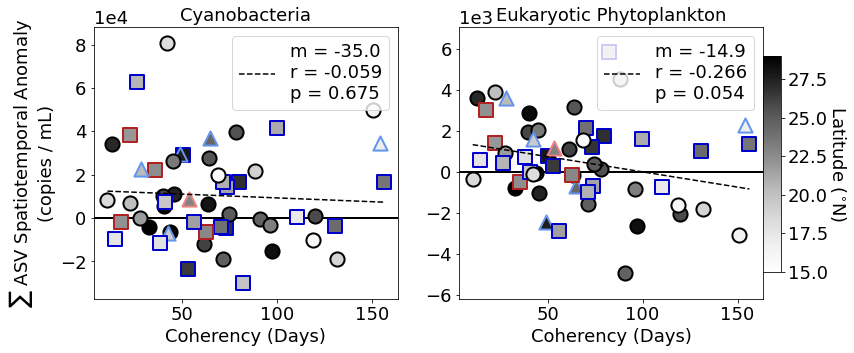

In [43]:
fig,ax = plt.subplots(1,2,figsize=(12,5)) # (width,height)

sc = sub_plot_param_v_coherence(ax[0],div_merged_df.Cyanobacteria,div_merged_df.CMEMS_avg_coh,colorbar='lat',
                           include_cyc=True,include_anti=True,include_bg=True)
sub_plot_param_v_coherence(ax[1],div_merged_df.Eukaryotes,div_merged_df.CMEMS_avg_coh,colorbar='lat',
                           include_cyc=True,include_anti=True,include_bg=True)


for i, a in enumerate(ax.flat):
    a.axhline(0,c='k',linewidth=2,zorder=0)

ax[0].set_ylabel('$\sum$ ASV Spatiotemporal Anomaly\n(copies / mL)')
ax[0].set_title('Cyanobacteria')
ax[1].set_title('Eukaryotic Phytoplankton')
ax[0].set_xlabel('Coherency (Days)')
ax[1].set_xlabel('Coherency (Days)')

# Colorbar
cb_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6]) # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cb_ax)
cb_ax.tick_params(axis='both', labelsize=fontsize)
cb_ax.set_ylabel('Latitude ($^{\circ}$N)',rotation=270,labelpad=20,fontsize=fontsize)    


OSCAR coherency

/var/folders/yd/5vf5xvpn14q42xgt5trcdktc0000gn/T/ipykernel_95026/3031402042.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


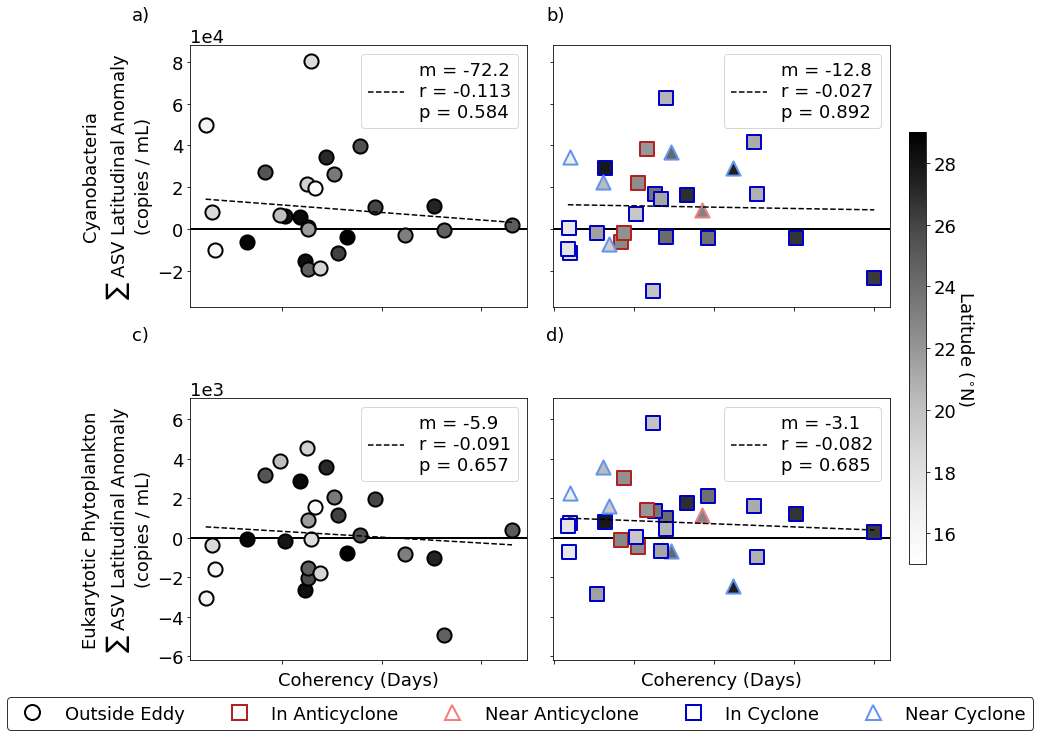

In [44]:
fig,ax = plt.subplots(2,2,figsize=(12,10)) # (width,height)

sc = sub_plot_param_v_coherence(ax[0,0],div_merged_df.Cyanobacteria,div_merged_df.OSCAR_avg_coh,colorbar='lat',
                           include_cyc=False,include_anti=False,include_bg=True)
sub_plot_param_v_coherence(ax[0,1],div_merged_df.Cyanobacteria,div_merged_df.OSCAR_avg_coh,colorbar='lat',
                           include_cyc=True,include_anti=True,include_bg=False)
sub_plot_param_v_coherence(ax[1,0],div_merged_df.Eukaryotes,div_merged_df.OSCAR_avg_coh,colorbar='lat',
                           include_cyc=False,include_anti=False,include_bg=True)
sub_plot_param_v_coherence(ax[1,1],div_merged_df.Eukaryotes,div_merged_df.OSCAR_avg_coh,colorbar='lat',
                            include_cyc=True,include_anti=True,include_bg=False)


for i, a in enumerate(ax.flat):
    a.axhline(0,c='k',linewidth=2,zorder=0)

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])

ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
ax[1,0].set_xticklabels([])
ax[1,1].set_xticklabels([])

ax[0,0].set_ylabel('Cyanobacteria\n$\sum$ ASV Latitudinal Anomaly\n(copies / mL)')
ax[1,0].set_ylabel('Eukarytotic Phytoplankton\n$\sum$ ASV Latitudinal Anomaly\n(copies / mL)')

ax[1,0].set_xlabel('Coherency (Days)')
ax[1,1].set_xlabel('Coherency (Days)')

ax[0,0].text(-25,10**5,'a)')
ax[0,1].text(-5,10**5,'b)')
ax[1,0].text(-25,10**4,'c)')
ax[1,1].text(-5,10**4,'d)')

# Colorbar
cb_ax = fig.add_axes([1, 0.2, 0.02, 0.6]) # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cb_ax)
cb_ax.tick_params(axis='both', labelsize=fontsize)
cb_ax.set_ylabel('Latitude ($^{\circ}$N)',rotation=270,labelpad=20,fontsize=fontsize)    

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Outside Eddy', markeredgecolor='k', markersize=15,markeredgewidth=2),
                  Line2D([0], [0], marker='s', color='w', label='In Anticyclone', markeredgecolor='firebrick', markersize=15,markeredgewidth=2),
                  Line2D([0], [0], marker='^', color='w', label='Near Anticyclone', markeredgecolor='lightcoral', markersize=15,markeredgewidth=2),
                  Line2D([0], [0], marker='s', color='w', label='In Cyclone', markeredgecolor='mediumblue', markersize=15,markeredgewidth=2),
                  Line2D([0], [0], marker='^', color='w', label='Near Cyclone', markeredgecolor='cornflowerblue', markersize=15,markeredgewidth=2)]
#plt.legend(handles=legend_elements, bbox_to_anchor=(0, 0.5))

plt.tight_layout()
legend = plt.legend(handles=legend_elements,
    loc="lower center", # "upper center" puts it below the line
    ncol=5,
    bbox_to_anchor=(0.55, -0.03),
    borderaxespad=0,
    bbox_transform=fig.transFigure 
)

legend.legendPatch.set_edgecolor("k")

plt.show()

### Plot each euk group seperately

Color scheme matches `lat_diel_running_means_v3.ipynb` 

In [45]:
euk_color_dict = {'Prymnesiophyte':['#4056A1'],
             'Dinoflagellate':['#9269b5'],
             'Dictyochophyte':['#ad2713'],
             'Chrysophyte':['#376E6F'],
             'Unknown Eukaryote Chloroplast':['#808080'],
             'Pelagophyte':['#D79922'],
             'Diatom':['#E98074'],
             'Chlorophyte':['#88BDBC'],
             'Prasinodermophyte':['#899c75'],
             'Cryptophyte':['#e6ccb3']}

Significant groups for main text

In [46]:
stat_table = [['slope','r','p']]

Text(-0.55, 1.12, 'a)')

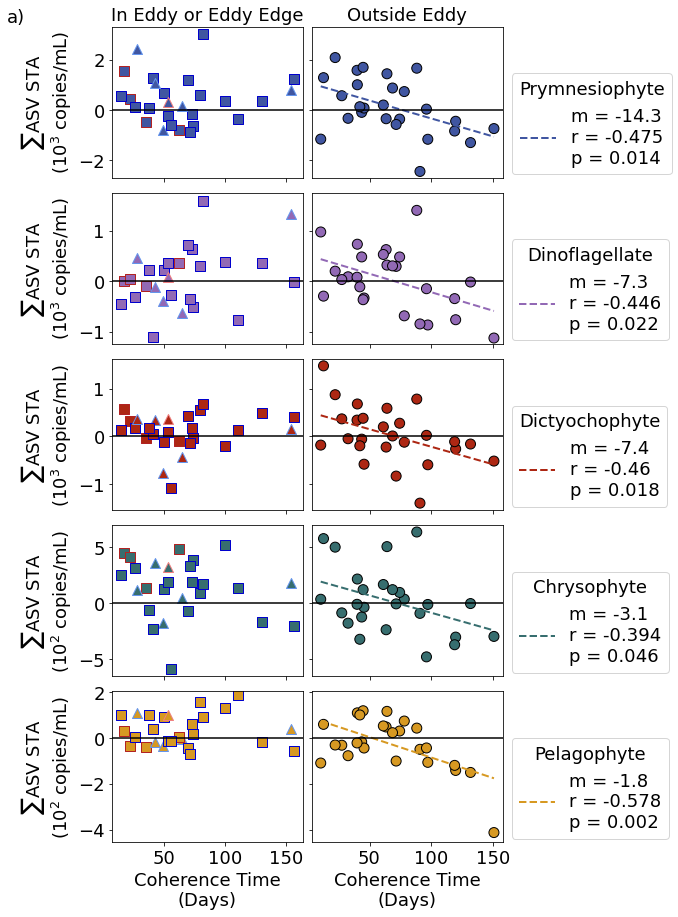

In [47]:
fig,ax = plt.subplots(5,2,figsize=(7,15)) # (width,height)
plt.subplots_adjust(wspace=0.05,hspace=0.1)

# Out of eddy inds / coherence
bg_inds = div_merged_df['eddy_color'].eq('k')
bg_x = div_merged_df.CMEMS_avg_coh[bg_inds]
bg_x_sorted = sorted(bg_x) # used for regression

# In eddy inds / coherence
eddy_inds = div_merged_df['eddy_color'].ne('k')
eddy_x = div_merged_df.CMEMS_avg_coh[eddy_inds]
eddy_x_sorted = sorted(eddy_x)

count = 0    
for col in ['Prymnesiophyte', 'Dinoflagellate', 'Dictyochophyte', 'Chrysophyte', 'Pelagophyte']:
    if col in ['Prymnesiophyte', 'Dinoflagellate', 'Dictyochophyte']:
        pwr = 3
    else:
        pwr = 2
    
    #### IN EDDY ####
    eddy_y = np.divide(div_merged_df[col][eddy_inds],10**pwr) # dividing by 10^pwr to have smaller numbers in plot

    # Fit lin. regression to data
    slope, intercept, r_value, p_value, std_err = spy.linregress(eddy_x, eddy_y)
    fit = [slope*i+intercept for i in eddy_x_sorted]

    edgecolors = list(div_merged_df[eddy_inds]['eddy_color'])
    for e in np.arange(0,len(edgecolors)):
        if (edgecolors[e] == 'mediumblue') or (edgecolors[e] == 'firebrick'):
            marker='s'
        elif (edgecolors[e] == 'cornflowerblue') or (edgecolors[e] == 'lightcoral'):
            marker='^'
        else:
            marker = 'circle'
        sc = ax[count,0].scatter(list(eddy_x)[e],list(eddy_y)[e],c=euk_color_dict[col][0],
                       edgecolor=edgecolors[e],marker=marker,s=100)
    #ax[count,0].plot(eddy_x_sorted,fit,linestyle='--',c=euk_color_dict[col][0],label='%s'%(col))

    #### NOT EDDY ####

    bg_y = np.divide(div_merged_df[col][bg_inds],10**pwr)

    # FIT REGRESSION TO DATA
    slope, intercept, r_value, p_value, std_err = spy.linregress(bg_x, bg_y)
    stat_table.append([col,round(slope*(10**pwr),2),round(r_value,3),round(p_value,3)]) # need to put slope back in correct units
    fit = [slope*i+intercept for i in bg_x_sorted]
    ax[count,1].scatter(bg_x,bg_y,c=euk_color_dict[col][0],s=100,
                        edgecolor=list(div_merged_df[bg_inds]['eddy_color']))
    ax[count,1].plot(bg_x_sorted,fit,linewidth=2,linestyle='--',c=euk_color_dict[col][0],
                     label='m = %s\nr = %s\np = %s'%(round(slope*(10**pwr),1),round(r_value,3),round(p_value,3)))
    ax[count,1].legend(title=col, bbox_to_anchor=(1,0.75))
    
    #### PARAMS ####
    ax[count,0].set_ylabel('$\sum$ASV STA\n($10^%s$ copies/mL)'%(pwr))
    
    # Ylims
    ymin = np.min(list(eddy_y)+list(bg_y))-(np.abs(np.min(list(eddy_y)+list(bg_y)))/10)
    ymax = np.max(list(eddy_y)+list(bg_y))+(np.max(list(eddy_y)+list(bg_y))/10)
    ax[count,0].set_ylim([ymin,ymax])
    ax[count,1].set_ylim([ymin,ymax])
    ax[count,1].set_yticklabels([])
    
    ax[count,0].axhline(0,c='k')
    ax[count,1].axhline(0,c='k')
    
    if count != 4:
        ax[count,0].set_xticklabels([])
        ax[count,1].set_xticklabels([])
    
    count += 1

ax[0,0].set_title('In Eddy or Eddy Edge')
ax[0,1].set_title('Outside Eddy')
ax[4,0].set_xlabel('Coherence Time\n(Days)')
ax[4,1].set_xlabel('Coherence Time\n(Days)')

ax[0,0].text(-0.55, 1.12, 'a)',transform=ax[0,0].transAxes,va='top',ha='left')

#plt.savefig(euk_paper_dir + '/figs/supp/prelim/major_euk_group_STA_vs_coh_v3.pdf',dpi=350,bbox_inches='tight',format='pdf')

Minor groups for supp

Text(-0.55, 1.12, 'b)')

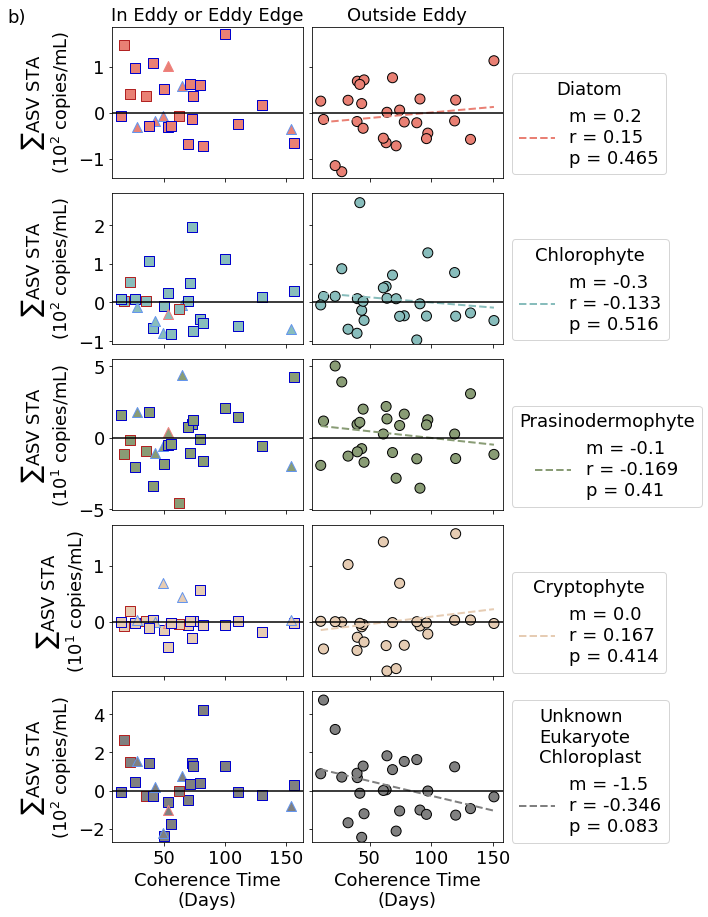

In [48]:
fig,ax = plt.subplots(5,2,figsize=(7,15)) # (width,height)
plt.subplots_adjust(wspace=0.05,hspace=0.1)

# Out of eddy inds / coherence
bg_inds = div_merged_df['eddy_color'].eq('k')
bg_x = div_merged_df.CMEMS_avg_coh[bg_inds]
bg_x_sorted = sorted(bg_x) # used for regression

# In eddy inds / coherence
eddy_inds = div_merged_df['eddy_color'].ne('k')
eddy_x = div_merged_df.CMEMS_avg_coh[eddy_inds]
eddy_x_sorted = sorted(eddy_x)

count = 0    
for col in ['Diatom', 'Chlorophyte','Prasinodermophyte', 'Cryptophyte','Unknown Eukaryote Chloroplast']:
    if col in ['Diatom', 'Chlorophyte','Unknown Eukaryote Chloroplast']:
        pwr = 2
    else:
        pwr = 1
    
    #### IN EDDY ####
    eddy_y = np.divide(div_merged_df[col][eddy_inds],10**pwr) 

    # Fit lin. regression to data
    slope, intercept, r_value, p_value, std_err = spy.linregress(eddy_x, eddy_y)
    fit = [slope*i+intercept for i in eddy_x_sorted]

    edgecolors = list(div_merged_df[eddy_inds]['eddy_color'])
    for e in np.arange(0,len(edgecolors)):
        if (edgecolors[e] == 'mediumblue') or (edgecolors[e] == 'firebrick'):
            marker='s'
        elif (edgecolors[e] == 'cornflowerblue') or (edgecolors[e] == 'lightcoral'):
            marker='^'
        else:
            marker = 'circle'
        sc = ax[count,0].scatter(list(eddy_x)[e],list(eddy_y)[e],c=euk_color_dict[col][0],
                       edgecolor=edgecolors[e],marker=marker,s=100)
    #ax[count,0].plot(eddy_x_sorted,fit,linestyle='--',c=euk_color_dict[col][0],label='%s'%(col))

    #### NOT EDDY ####

    bg_y = np.divide(div_merged_df[col][bg_inds],10**pwr)

    # FIT REGRESSION TO DATA
    slope, intercept, r_value, p_value, std_err = spy.linregress(bg_x, bg_y)
    stat_table.append([col,round(slope*(10**pwr),2),round(r_value,3),round(p_value,3)]) # need to put slope back in correct units
    fit = [slope*i+intercept for i in bg_x_sorted]
    ax[count,1].scatter(bg_x,bg_y,c=euk_color_dict[col][0],s=100,
                        edgecolor=list(div_merged_df[bg_inds]['eddy_color']))
    ax[count,1].plot(bg_x_sorted,fit,linewidth=2,linestyle='--',c=euk_color_dict[col][0],
                     label='m = %s\nr = %s\np = %s'%(round(slope*(10**pwr),1),round(r_value,3),round(p_value,3)))
    if col == 'Unknown Eukaryote Chloroplast':
        ax[count,1].legend(title='Unknown\nEukaryote\nChloroplast', bbox_to_anchor=(1,1))
    else:
        ax[count,1].legend(title=col, bbox_to_anchor=(1,0.75))
    
    #### PARAMS ####
    ax[count,0].set_ylabel('$\sum$ASV STA\n($10^%s$ copies/mL)'%(pwr))
    
    # Ylims
    ymin = np.min(list(eddy_y)+list(bg_y))-(np.abs(np.min(list(eddy_y)+list(bg_y)))/10)
    ymax = np.max(list(eddy_y)+list(bg_y))+(np.max(list(eddy_y)+list(bg_y))/10)
    ax[count,0].set_ylim([ymin,ymax])
    ax[count,1].set_ylim([ymin,ymax])
    ax[count,1].set_yticklabels([])
    
    ax[count,0].axhline(0,c='k')
    ax[count,1].axhline(0,c='k')
    
    if count != 4:
        ax[count,0].set_xticklabels([])
        ax[count,1].set_xticklabels([])
    
    count += 1

ax[0,0].set_title('In Eddy or Eddy Edge')
ax[0,1].set_title('Outside Eddy')
ax[4,0].set_xlabel('Coherence Time\n(Days)')
ax[4,1].set_xlabel('Coherence Time\n(Days)')

ax[0,0].text(-0.55, 1.12, 'b)',transform=ax[0,0].transAxes,va='top',ha='left')

#plt.savefig(euk_paper_dir + '/figs/supp/prelim/minor_euk_group_STA_vs_coh_v3.pdf',dpi=350,bbox_inches='tight',format='pdf')

## Table S3

In [49]:
fit_dict = {}
for row in stat_table[1:]:
    fit_dict[row[0]] = row[1:] # ['slope','r','p']
fit_dict

{'Prymnesiophyte': [-14.32, -0.475, 0.014],
 'Dinoflagellate': [-7.32, -0.446, 0.022],
 'Dictyochophyte': [-7.39, -0.46, 0.018],
 'Chrysophyte': [-3.12, -0.394, 0.046],
 'Pelagophyte': [-1.79, -0.578, 0.002],
 'Diatom': [0.24, 0.15, 0.465],
 'Chlorophyte': [-0.27, -0.133, 0.516],
 'Prasinodermophyte': [-0.09, -0.169, 0.41],
 'Cryptophyte': [0.03, 0.167, 0.414],
 'Unknown Eukaryote Chloroplast': [-1.54, -0.346, 0.083]}

In [50]:
euk_grp_table = pd.read_csv(euk_paper_dir + 'euk_gp_table.csv',index_col=0)
euk_grp_table['STA vs Coherence slope (copies/mL/d)'] = [np.nan]*len(euk_grp_table)
euk_grp_table['Pearson\'s r'] = [np.nan]*len(euk_grp_table)
euk_grp_table['p-val'] = [np.nan]*len(euk_grp_table)
euk_grp_table

,Mean (copies/mL),Std. Dev.,CV (%),STA vs Coherence slope (copies/mL/d),Pearson's r,p-val
Group,,,,,,
All,20453.1,3569.5,17.5,NaN,NaN,NaN
Prymnesiophyte,7582.6,1736.1,22.9,NaN,NaN,NaN
Dinoflagellate,4220.3,886.6,21.0,NaN,NaN,NaN
Dictyochophyte,3907.0,987.3,25.3,NaN,NaN,NaN
Chrysophyte,2369.3,645.9,27.3,NaN,NaN,NaN
Unknown Eukaryote Chloroplast,1203.6,395.3,32.8,NaN,NaN,NaN
Pelagophyte,602.4,131.1,21.8,NaN,NaN,NaN
Diatom,307.4,119.0,38.7,NaN,NaN,NaN
Chlorophyte,207.3,130.4,62.9,NaN,NaN,NaN


In [51]:
# hard-coded based on fig
euk_grp_table.loc['All']['STA vs Coherence slope (copies/mL/d)'] = -35.6
euk_grp_table.loc['All']['Pearson\'s r'] = -0.565
euk_grp_table.loc['All']['p-val'] = 0.003

for group in euk_grp_table.index[1:]:
    euk_grp_table.loc[group]['STA vs Coherence slope (copies/mL/d)'] = fit_dict[group][0]
    euk_grp_table.loc[group]['Pearson\'s r'] = fit_dict[group][1]
    euk_grp_table.loc[group]['p-val'] = fit_dict[group][2]
euk_grp_table

,Mean (copies/mL),Std. Dev.,CV (%),STA vs Coherence slope (copies/mL/d),Pearson's r,p-val
Group,,,,,,
All,20453.1,3569.5,17.5,-35.60,-0.565,0.003
Prymnesiophyte,7582.6,1736.1,22.9,-14.32,-0.475,0.014
Dinoflagellate,4220.3,886.6,21.0,-7.32,-0.446,0.022
Dictyochophyte,3907.0,987.3,25.3,-7.39,-0.460,0.018
Chrysophyte,2369.3,645.9,27.3,-3.12,-0.394,0.046
Unknown Eukaryote Chloroplast,1203.6,395.3,32.8,-1.54,-0.346,0.083
Pelagophyte,602.4,131.1,21.8,-1.79,-0.578,0.002
Diatom,307.4,119.0,38.7,0.24,0.150,0.465
Chlorophyte,207.3,130.4,62.9,-0.27,-0.133,0.516


In [52]:
#euk_grp_table.to_csv(euk_paper_dir + 'euk_group_stats_v3.csv')

## STA averages

Create table with in eddy, eddy edge, and outside eddy means and standard deviations 

In [53]:
div_merged_df.set_index('sample_id', inplace=True)
div_merged_df.head()

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,eddy_age_days,eddy_age_frac,...,Unknown Eukaryote Chloroplast,Pelagophyte,Diatom,Chlorophyte,Prasinodermophyte,Cryptophyte,Diazotroph,Picocyanobacteria,Eukaryotes,Cyanobacteria
sample_id,,,,,,,,,,,,,,,,,,,,,
16,20211120,10:54,29.0000,236.5574,0,0,0,0,NaN,NaN,...,-168.192228,-76.805029,27.143210,-69.382566,-12.848812,10.185406,-6.580226,-3967.232713,-763.507255,-3973.812939
17,20211120,12:44,28.7390,236.1088,0,0,0,0,NaN,NaN,...,-244.454688,-16.290086,20.008678,-20.601396,-7.666102,-0.882804,-16.200813,-6257.738603,-67.314424,-6273.939416
18,20211120,14:43,28.5030,235.7140,0,0,0,0,NaN,NaN,...,68.056802,110.829831,68.528971,9.576012,-9.852365,-2.745265,-0.984962,5610.385205,2876.148602,5609.400243
19,20211121,02:03,28.2847,235.3517,0,0,0,0,NaN,NaN,...,-1.901571,-105.905127,-44.062083,127.923658,12.454472,-2.172479,-28.346925,-15423.968296,-2653.782135,-15452.315221
20,20211121,04:04,28.0397,234.9534,0,0,0,0,NaN,NaN,...,4.178096,48.921635,-64.909874,41.297409,21.731504,-4.229902,7.394596,6379.209983,-139.829386,6386.604579


In [54]:
out_inds = div_merged_df[div_merged_df.eddy_color == 'k'].index
in_inds = div_merged_df[(div_merged_df.eddy_color == 'mediumblue') | (div_merged_df.eddy_color == 'firebrick')].index
edge_inds = div_merged_df[(div_merged_df.eddy_color == 'cornflowerblue') | (div_merged_df.eddy_color == 'lightcoral')].index

print(len(out_inds))
print(len(in_inds))
print(len(edge_inds))

26
21
6


In [55]:
table_groups = [
 'Cyanobacteria',
 'Eukaryotes',
 'Prymnesiophyte', 
 'Dinoflagellate', 
 'Dictyochophyte', 
 'Chrysophyte', 
 'Pelagophyte',
 'Diatom', 
 'Chlorophyte',
 'Prasinodermophyte', 
 'Cryptophyte',
 'Unknown Eukaryote Chloroplast']

In [56]:
avg_STA_columns = ['In Eddy $\overline{X}$','In Eddy $\sigma$','Eddy Edge $\overline{X}$','Eddy Edge $\sigma$','Outside Eddy $\overline{X}$','Outside Eddy $\sigma$']
avg_STA_table = []

for grp in table_groups:
    temp_row = []
    for inds in [in_inds,edge_inds,out_inds]:
        temp_row.append(round(np.mean(div_merged_df[grp].loc[inds]),2))
        temp_row.append(round(np.std(div_merged_df[grp].loc[inds]),2))
    avg_STA_table.append(temp_row)
    
avg_STA_df = pd.DataFrame(avg_STA_table,columns=avg_STA_columns,index=table_groups)
avg_STA_df

,In Eddy $\overline{X}$,In Eddy $\sigma$,Eddy Edge $\overline{X}$,Eddy Edge $\sigma$,Outside Eddy $\overline{X}$,Outside Eddy $\sigma$
Cyanobacteria,7993.67,21793.72,20800.34,15481.59,10039.16,22437.90
Eukaryotes,781.95,1680.72,925.09,1982.96,207.71,2276.75
Prymnesiophyte,343.90,922.11,668.40,974.30,134.45,1090.67
Dinoflagellate,67.04,561.24,125.47,639.11,27.22,593.52
Dictyochophyte,125.52,368.58,4.25,443.43,26.35,580.55
Chrysophyte,136.33,273.06,142.86,181.55,16.84,286.52
Pelagophyte,35.25,72.31,33.12,56.53,-25.44,112.19
Diatom,23.07,66.41,11.27,50.64,-7.32,57.94
Chlorophyte,9.75,66.50,-41.02,26.91,8.51,71.90
Prasinodermophyte,-2.12,19.33,5.04,20.95,2.90,19.98


In [57]:
#avg_STA_df.to_csv(euk_paper_dir + 'avg_STA_by_group_v3.csv')

## Exponential Decay of Abundance

The solution for $\frac{1}{C}\frac{DC}{DT} = \mu$ is $C(t) = N_0 e^{\mu t}$. Here we simulate the temporal transformation of a population entering a coherent water mass, given the STAs of outside-eddy populations.

First, we create an artificial dataset of abundance by adding the outside-eddy STAs to the average abundance. Then, we fit an exponential to derive the e-folding time. 

In [58]:
phyto_group_abund_df = pd.read_csv(highcov_dir + 'group_level_abs_ASV_abundance_IS_avg_station_avg_phytoplankon_filtered.csv',index_col=0)
phyto_group_abund_df.head()

,Chlorophyte,Chrysophyte,Cryptophyte,Diatom,Diazotroph,Dictyochophyte,Dinoflagellate,Pelagophyte,Picocyanobacteria,Prasinodermophyte,Prymnesiophyte,Unknown Eukaryote Chloroplast
sample_id,,,,,,,,,,,,
16,110.048054,1240.167125,16.999746,275.804371,15.966064,3544.225935,3205.385190,574.908487,156265.737383,3.659004,5865.537110,854.617607
17,141.221169,1478.917838,0.000000,289.653305,17.011887,3779.370939,3828.104849,642.488469,167018.718590,8.158246,6470.224888,784.684933
18,165.653141,1798.307663,0.000000,345.657441,31.017010,4464.900185,4319.723707,743.954263,176434.258828,4.325177,7516.011736,1064.202615
19,339.989462,1315.965788,0.000000,203.377400,0.000000,2163.227938,2178.996038,465.571158,156331.380406,32.351655,4201.516817,810.499092
20,212.412926,1285.449856,0.000000,194.655637,78.427659,2924.505816,4194.065450,623.309179,171497.237077,46.232985,5788.625662,979.633590


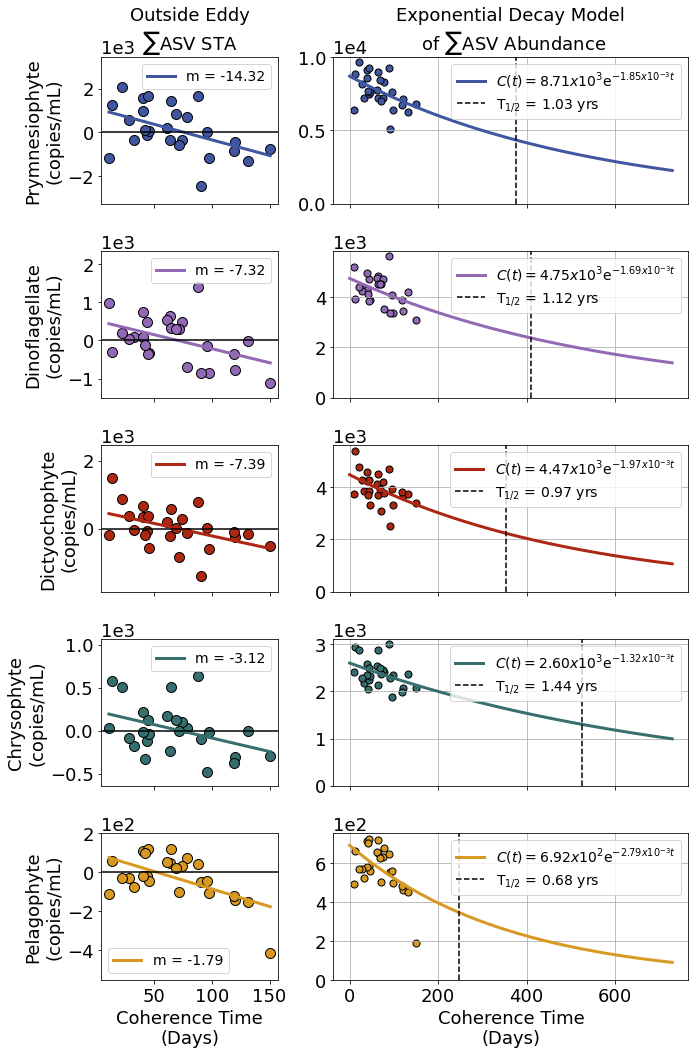

In [59]:
fig,ax = plt.subplots(5,2,figsize=(10,15), gridspec_kw={'width_ratios': [1, 2]}) # (width,height)

# Out of eddy inds / coherence
bg_inds = div_merged_df['eddy_color'].eq('k')
bg_x = div_merged_df.CMEMS_avg_coh[bg_inds]
bg_x_sorted = sorted(bg_x) # used for regression

def exponential_decay(t, N0, tau):
    return N0 * np.exp(-t / tau) 

def sci_notation(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return "%sx10^{%s}"%(a,b)

count = 0    
for col in ['Prymnesiophyte', 'Dinoflagellate', 'Dictyochophyte', 'Chrysophyte', 'Pelagophyte']:

    ################ OUTSIDE EDDY STA ################

    bg_y = div_merged_df[col][bg_inds]
    slope, intercept, r_value, p_value, std_err = spy.linregress(bg_x, bg_y)
    fit = [slope*i+intercept for i in bg_x_sorted]
    
    ax[count,0].scatter(bg_x,bg_y,c=euk_color_dict[col][0],s=100,edgecolor='k')
    ax[count,0].plot(bg_x_sorted,fit,linewidth=3,c=euk_color_dict[col][0],
                     label='m = %s'%(round(slope,2)))
    ax[count,0].legend(fontsize=14)
    
    ################ EXPONENTIAL DECAY MODEL ################

    x = np.array(div_merged_df.CMEMS_avg_coh[bg_inds]) # time (days)
    y = euk_grp_table['Mean (copies/mL)'][col] + np.array(div_merged_df[col][bg_inds]) # mean abundance + STA 
    
    #y = np.mean(phyto_group_abund_df[col]) + np.array(div_merged_df[col][bg_inds]) # mean abundance + STA 
    params, param_cov = curve_fit(exponential_decay, x, y, p0=[max(y),100])
    N0_fit, tau_fit = params[0],params[1]
    half_life = round(tau_fit*np.log(2))
    
    x_extended = np.arange(0,365*2) # Model 2 years
    ax[count,1].scatter(x,y,c=euk_color_dict[col][0],s=50,edgecolor='k')
    ax[count,1].plot(x_extended,exponential_decay(x_extended, N0_fit, tau_fit),
                     c=euk_color_dict[col][0],linewidth=3,
                     label="$C(t)=%s$e$^{-%st}$"%(sci_notation(N0_fit),sci_notation(1/tau_fit)))
    
    
    
    ax[count,1].axvline(half_life,c='k',linestyle='--',label='T$_{1/2}$ = %s yrs'%(round(half_life/365,2)))
    ax[count,1].set_ylim(bottom=0)    
    ax[count,1].grid()
    ax[count,1].legend(loc='upper right',fontsize=14)
    
    #### PARAMS ####
    ax[count,0].set_ylabel('%s\n(copies/mL)'%(col))
    ax[count,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[count,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    
    # Ylims
    ymin = np.min(list(bg_y))-(np.abs(np.min(list(bg_y)))/3)
    ymax = np.max(list(bg_y))+(2*(np.max(list(bg_y))/3))
    ax[count,0].set_ylim([ymin,ymax])
    ax[count,0].axhline(0,c='k')
    
    if count != 4:
        ax[count,0].set_xticklabels([])
        ax[count,1].set_xticklabels([])
    
    count += 1

ax[0,0].set_title('Outside Eddy\n$\sum$ASV STA')
ax[0,1].set_title('Exponential Decay Model\n of $\sum$ASV Abundance')

ax[4,0].set_xlabel('Coherence Time\n(Days)')
ax[4,1].set_xlabel('Coherence Time\n(Days)')

plt.tight_layout()
#plt.savefig(euk_paper_dir + '/figs/major_euk_group_exp_model.pdf',dpi=350,bbox_inches='tight',format='pdf')

Text(0.5, 0, 'Coherence Time (Days)')

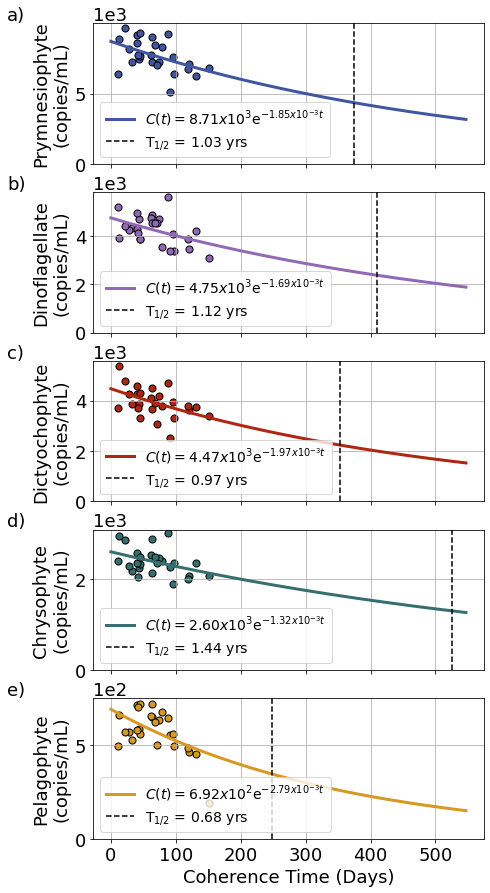

In [60]:
fig,ax = plt.subplots(5,1,figsize=(7,15)) # (width,height)

# Out of eddy inds / coherence
bg_inds = div_merged_df['eddy_color'].eq('k')
bg_x = div_merged_df.CMEMS_avg_coh[bg_inds]
bg_x_sorted = sorted(bg_x) # used for regression

panel_labels = ['a)','b)','c)','d)','e)']

def exponential_decay(t, N0, tau):
    return N0 * np.exp(-t / tau) 

def sci_notation(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return "%sx10^{%s}"%(a,b)

count = 0    
for col in ['Prymnesiophyte', 'Dinoflagellate', 'Dictyochophyte', 'Chrysophyte', 'Pelagophyte']:

    x = np.array(div_merged_df.CMEMS_avg_coh[bg_inds]) # time (days)
    y = euk_grp_table['Mean (copies/mL)'][col] + np.array(div_merged_df[col][bg_inds]) # mean abundance + STA 
    
    params, param_cov = curve_fit(exponential_decay, x, y, p0=[max(y),100])
    N0_fit, tau_fit = params[0],params[1]
    half_life = round(tau_fit*np.log(2))
    
    x_extended = np.arange(0,365*1.5) # How many years to plot?
    ax[count].scatter(x,y,c=euk_color_dict[col][0],s=50,edgecolor='k')
    ax[count].plot(x_extended,exponential_decay(x_extended, N0_fit, tau_fit),
                     c=euk_color_dict[col][0],linewidth=3,
                     label="$C(t)=%s$e$^{-%st}$"%(sci_notation(N0_fit),sci_notation(1/tau_fit)))
    
    
    ax[count].axvline(half_life,c='k',linestyle='--',label='T$_{1/2}$ = %s yrs'%(round(half_life/365,2)))
    ax[count].set_ylim(bottom=0)    
    ax[count].grid()
    ax[count].legend(loc='lower left',fontsize=14)
    
    #### PARAMS ####
    ax[count].text(-0.22, 1.12, panel_labels[count],transform=ax[count].transAxes,va='top',ha='left')
    ax[count].set_ylabel('%s\n(copies/mL)'%(col))
    ax[count].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  
    if count != 4:
        ax[count].set_xticklabels([])
    
    count += 1

ax[4].set_xlabel('Coherence Time (Days)')

#plt.savefig(euk_paper_dir + '/figs/major_euk_group_exp_model.pdf',dpi=350,bbox_inches='tight',format='pdf')

### Zoom-in Version

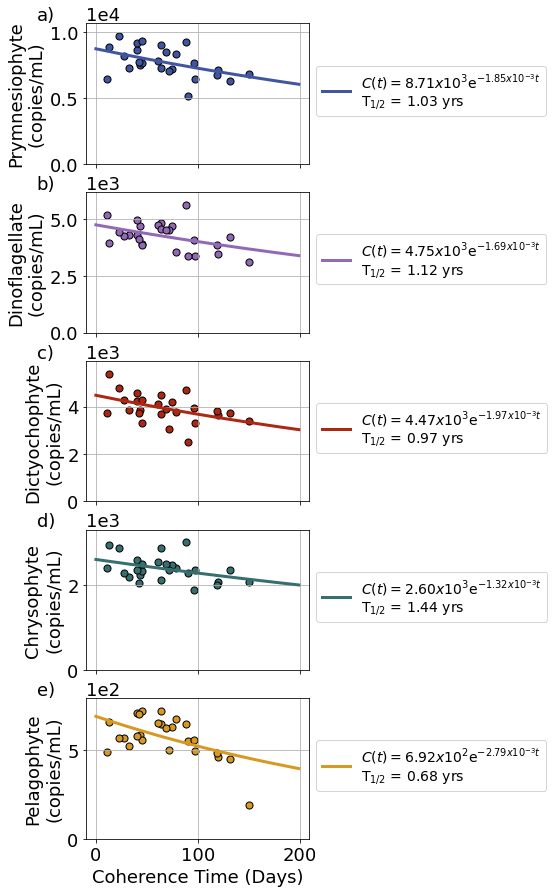

In [80]:
fig,ax = plt.subplots(5,1,figsize=(4,15)) # (width,height)

# Out of eddy inds / coherence
bg_inds = div_merged_df['eddy_color'].eq('k')
bg_x = div_merged_df.CMEMS_avg_coh[bg_inds]
bg_x_sorted = sorted(bg_x) # used for regression

panel_labels = ['a)','b)','c)','d)','e)']

def exponential_decay(t, N0, tau):
    return N0 * np.exp(-t / tau) 

def sci_notation(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return "%sx10^{%s}"%(a,b)

count = 0    
for col in ['Prymnesiophyte', 'Dinoflagellate', 'Dictyochophyte', 'Chrysophyte', 'Pelagophyte']:

    # Scatter Data
    x = np.array(div_merged_df.CMEMS_avg_coh[bg_inds]) # time (days)
    y = euk_grp_table['Mean (copies/mL)'][col] + np.array(div_merged_df[col][bg_inds]) # mean abundance + STA 
    
    # Fit Model
    params, param_cov = curve_fit(exponential_decay, x, y, p0=[max(y),100])
    N0_fit, tau_fit = params[0],params[1]
    half_life = round(tau_fit*np.log(2))
    y_pred = exponential_decay(x, N0_fit, tau_fit)
    
    # Calculate R^2 of Model Fit
    r2 = r2_score(y,y_pred) # (y_data,y_predicted)
    
    
    x_extended = np.arange(0,200) # How many days to plot?
    ax[count].scatter(x,y,c=euk_color_dict[col][0],s=50,edgecolor='k')
    ax[count].plot(x_extended,exponential_decay(x_extended, N0_fit, tau_fit),
                     c=euk_color_dict[col][0],linewidth=3,
                     label="$C(t)=%s$e$^{-%st}$\nT$_{1/2}$ = %s yrs"%(sci_notation(N0_fit),
                                                                      sci_notation(1/tau_fit),
                                                                      round(half_life/365,2)))
    
    ax[count].set_ylim([0,max(y)+0.1*max(y)])    
    ax[count].grid()
    ax[count].legend(bbox_to_anchor=(1,0.75),fontsize=14)
    
    #### PARAMS ####
    ax[count].text(-0.22, 1.12, panel_labels[count],transform=ax[count].transAxes,va='top',ha='left')
    ax[count].set_ylabel('%s\n(copies/mL)'%(col))
    ax[count].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  
    if count != 4:
        ax[count].set_xticklabels([])
    
    count += 1

ax[4].set_xlabel('Coherence Time (Days)')

#plt.savefig(euk_paper_dir + '/figs/major_euk_group_exp_model_v2.pdf',dpi=350,bbox_inches='tight',format='pdf')

## Eddy Enhancement Stats

Which groups are the most enhanced in each eddy?

In [52]:
eddy_dict = {849094:'Shrutie',
             799833:'Josh',
             847844:'Cathy',
             845344:'Koko',
             844202:'Dean',
             831329:'Zinka',
             823188:'Sharon'}

In [53]:
euk_groups = [
 'Prymnesiophyte', 
 'Dinoflagellate', 
 'Dictyochophyte', 
 'Chrysophyte', 
 'Pelagophyte',
 'Diatom', 
 'Chlorophyte',
 'Prasinodermophyte', 
 'Cryptophyte',
 'Unknown Eukaryote Chloroplast']

In [54]:
eddy_group_sum_dict = {} # eddy: group sum
for eddy in np.unique(div_merged_df['in_cyc']):
    if eddy != 0:
        print('**************** ' + eddy_dict[eddy] +' ****************')
        in_eddy_group_sums = div_merged_df[euk_groups].loc[div_merged_df[div_merged_df['in_cyc']==eddy].index].sum(axis=0)
        eddy_group_sum_dict[eddy_dict[eddy]] = in_eddy_group_sums
        print(in_eddy_group_sums.sort_values(ascending=False))
        
for eddy in np.unique(div_merged_df['in_anti']):
    if eddy != 0:
        print('**************** ' + eddy_dict[eddy] +' ****************')
        in_eddy_group_sums = div_merged_df[euk_groups].loc[div_merged_df[div_merged_df['in_anti']==eddy].index].sum(axis=0)
        eddy_group_sum_dict[eddy_dict[eddy]] = in_eddy_group_sums
        print(in_eddy_group_sums.sort_values(ascending=False))

**************** Sharon ****************
Chrysophyte                       969.919192
Diatom                            337.848603
Unknown Eukaryote Chloroplast     165.429149
Pelagophyte                        71.028949
Chlorophyte                        14.458600
Cryptophyte                        -0.823341
Prasinodermophyte                  -3.006340
Dinoflagellate                  -1054.520274
Dictyochophyte                  -1293.329717
Prymnesiophyte                  -1698.086991
dtype: float64
**************** Zinka ****************
Dinoflagellate                   1311.669920
Dictyochophyte                    818.747822
Chrysophyte                       462.019316
Pelagophyte                       207.559181
Chlorophyte                       175.837088
Prymnesiophyte                    174.880407
Unknown Eukaryote Chloroplast     125.547201
Diatom                             17.912982
Prasinodermophyte                   2.972898
Cryptophyte                        -1.789643
dtyp

### Diatom STAs

Sample 51: Cyc Sharon

Sample 46: Anti Josh

In [55]:
div_merged_df['Diatom'].sort_values(ascending=False)

sample_id
51     169.957396
46     147.252671
69     112.915353
57     107.006613
44     100.421065
53      96.998729
71      76.037414
23      71.362933
18      68.528971
52      63.362129
62      61.497774
25      60.361280
36      58.601908
21      51.753779
47      41.714804
44R     36.181964
50      35.912397
35      29.972427
30      27.675279
16      27.143210
61      25.298176
17      20.008678
37      16.896929
33       5.875242
32       1.105125
66      -6.048488
22      -6.303673
45      -7.648735
26     -12.439931
24     -14.438369
70     -17.622269
58     -17.713465
29     -18.926111
31     -19.924430
59     -21.617928
67     -24.554673
49     -28.382049
64     -28.817058
27     -30.008366
54     -31.524165
40     -33.583617
68     -35.837324
19     -44.062083
28     -55.144876
41     -56.006842
60     -57.650588
39     -64.641336
20     -64.909874
38     -68.608084
34     -71.631094
56     -71.680036
55    -114.542893
48    -127.782245
Name: Diatom, dtype: float64

### Eddy Distances

How similar are the eddies to each other?

In [56]:
def euclidean_distance(point1, point2):
    distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(point1, point2)]))
    return distance

In [57]:
for main_key in eddy_group_sum_dict.keys():
    print('**************** ' + main_key +' ****************')
    dists = {}
    for key,values in eddy_group_sum_dict.items():
        dists[key] = euclidean_distance(eddy_group_sum_dict[main_key], eddy_group_sum_dict[key])
        
    sorted_dists = dict(sorted(dists.items(), key=lambda item: item[1]))
    for key, value in sorted_dists.items():
        print('%s: %s'%(key,value))

**************** Sharon ****************
Sharon: 0.0
Koko: 2759.0531566507916
Shrutie: 3113.2845057542045
Josh: 3495.8706801413946
Zinka: 3738.2303700391617
Dean: 5794.104917068431
Cathy: 6611.0618273070595
**************** Zinka ****************
Zinka: 0.0
Josh: 1569.4131571378032
Shrutie: 1620.5444481211814
Koko: 2337.3922502220257
Dean: 2839.9894765419895
Sharon: 3738.2303700391617
Cathy: 4259.51409449381
**************** Dean ****************
Dean: 0.0
Cathy: 1865.8094068521377
Shrutie: 2745.0466465352533
Zinka: 2839.9894765419895
Josh: 3034.10042718456
Koko: 3466.492110524981
Sharon: 5794.104917068431
**************** Koko ****************
Koko: 0.0
Shrutie: 1489.7140183357133
Josh: 1927.6786733759839
Zinka: 2337.3922502220257
Sharon: 2759.0531566507916
Dean: 3466.492110524981
Cathy: 4335.05162020303
**************** Cathy ****************
Cathy: 0.0
Dean: 1865.8094068521377
Shrutie: 3777.629240492402
Josh: 3934.572503992024
Zinka: 4259.51409449381
Koko: 4335.05162020303
Sharon: 6